# Variational Quantum Eigensolver - Ground State Energy for $H2$ Molecule using the RYRZ ansatz¶

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-21 15:27:40,539: Credentials are already in use. The existing account in the session will be replaced.


In [16]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [17]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for $H2$ molecule at equilibrium bond length 0.735 Angstrom

In [18]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [19]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [20]:
def initial_state_preparation(dist: float, mapper_str: str = "jw"):
    
    molecule = "H 0.0 0.0 0.0; H 0.0 0.0 " + str(dist)
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [21]:
inter_atomic_dists: list = np.arange(0.45, 2.05, 0.05)

In [22]:
numpy_eigensolver_electronic_ground_energies: list = []
numpy_eigensolver_nuclear_repulsion_energies: list = []
numpy_eigensolver_total_ground_state_energies: list = []

from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

print("Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    # construct NumPyEigensolver - solver algorithm
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    # calculate excited states using the NumPyEigensolver solver algorithm
    numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
    # Compute Ground and Excited States properties.
    numpy_ground_excited_states_properties = numpy_excited_states_calculation.solve(es_problem)
    
    # Get Repulsion energy from properties of ground and excited states
    nuclear_repulsion_energy = numpy_ground_excited_states_properties.nuclear_repulsion_energy
    numpy_eigensolver_nuclear_repulsion_energies.append(nuclear_repulsion_energy)
    
    # constructs NumPyMinimumEigensolver - solver algorithm
    numpy_minimum_solver = NumPyMinimumEigensolverFactory()
    # compute the ground state using a minimum eigensolver
    numpy_ground_state_calculation = GroundStateEigensolver(qubit_converter, numpy_minimum_solver)
    # Compute Ground state properties - returns an Eigenstate result
    numpy_ground_state_properties = numpy_ground_state_calculation.solve(es_problem)
    
    # Get electronic ground state energies
    electronic_ground_energy = np.real(numpy_ground_state_properties.eigenenergies[0])
    numpy_eigensolver_electronic_ground_energies.append(electronic_ground_energy)
    
    # Get the total ground state energy
    total_ground_state_energy = (electronic_ground_energy + nuclear_repulsion_energy)
    numpy_eigensolver_total_ground_state_energies.append(total_ground_state_energy)
    
    print("Interatomic dist: {:.4f} Å \t Electronic Ground Energy: {:.4f} Eh \tTotal Ground State Energy: {:.4f} Eh".format(dist, electronic_ground_energy, total_ground_state_energy))
    # print("Interatomic dist: {:.4f} Å \t Total Ground State Energy: {:.4f} Eh".format(dist, total_ground_state_energy))
   

Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm

Interatomic dist: 0.4500 Å 	 Electronic Ground Energy: -2.1744 Eh 	Total Ground State Energy: -0.9984 Eh
Interatomic dist: 0.5000 Å 	 Electronic Ground Energy: -2.1135 Eh 	Total Ground State Energy: -1.0552 Eh
Interatomic dist: 0.5500 Å 	 Electronic Ground Energy: -2.0548 Eh 	Total Ground State Energy: -1.0926 Eh
Interatomic dist: 0.6000 Å 	 Electronic Ground Energy: -1.9982 Eh 	Total Ground State Energy: -1.1163 Eh
Interatomic dist: 0.6500 Å 	 Electronic Ground Energy: -1.9440 Eh 	Total Ground State Energy: -1.1299 Eh
Interatomic dist: 0.7000 Å 	 Electronic Ground Energy: -1.8922 Eh 	Total Ground State Energy: -1.1362 Eh
Interatomic dist: 0.7500 Å 	 Electronic Ground Energy: -1.8427 Eh 	Total Ground State Energy: -1.1371 Eh
Interatomic dist: 0.8000 Å 	 Electronic Ground Energy: -1.7956 Eh 	Total Ground State Energy: -1.1341 Eh
Interatomic dist: 0.8500 Å 	 Electronic Ground Energy: -1.7509 Eh 	Total Gro

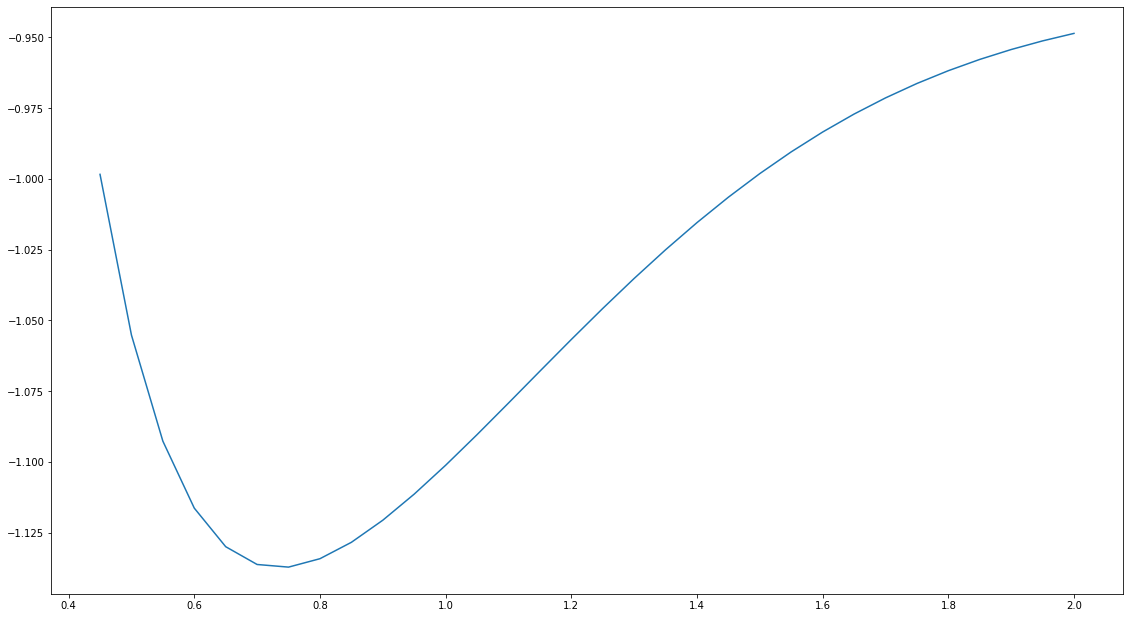

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies)
plt.show()

In [24]:
ryrz_electronic_ground_energies: list = []
ryrz_nuclear_repulsion_energies: list = []
ryrz_total_ground_state_energies: list = []

from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# provider = IBMQ.get_provider(hub='ibm-q')
# backend = provider.get_backend('ibmq_toronto')
backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend=backend)
optimizer = SLSQP(maxiter=5)
# optimizer = COBYLA(maxiter=10000)

print("Total Ground State Energies of H2 Molecule using RYRZ ansatz\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    # init_state.draw("mpl", initial_state=True)

    # Setting up TwoLocal for our ansatz
    ansatz_type = "RYRZ"

    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ["ry", "rz"]
    # Entangling gates
    entanglement_blocks = "cx"
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False

    ansatz = TwoLocal(
        qubit_op.num_qubits,
        rotation_blocks,
        entanglement_blocks,
        reps=repetitions,
        entanglement=entanglement,
        skip_final_rotation_layer=skip_final_rotation_layer,
        insert_barriers=True)

    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(
        ansatz,
        optimizer=optimizer,
        quantum_instance=state_sim,
        callback=callback,
        initial_point=initial_point
    )

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(result)
    ryrz_total_ground_state_energies.append( np.real(result.eigenvalue) )
    # print(np.real(result.eigenvalue))
    

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 45,
    'eigenstate': array([-0.70705435+3.42359969e-03j,  0.01065536+3.64909435e-05j,
       -0.00746219-5.34074860e-05j,  0.70702185-3.64661272e-03j]),
    'eigenvalue': (-1.1891297995794823+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[2]): -0.00010460842695442121,
                              ParameterVectorElement(θ[6]): -0.00010548696375077993,
                              ParameterVectorElement(θ[5]): -0.011334477667921613,
                              ParameterVectorElement(θ[4]): 0.006820631896796564,
                              ParameterVectorElement(θ[7]): -0.00010322338291705115,
                              ParameterVectorElement(θ[3]): 0.009999675955881679,
                              ParameterVectorElement(θ[1]): 0.025622462152447865,
                              ParameterVectorElement(θ[0]): 1.5706081157234422},
    'optimal_point': array([ 1.57060812e+00,  2.56224622e-02, -1.0460842

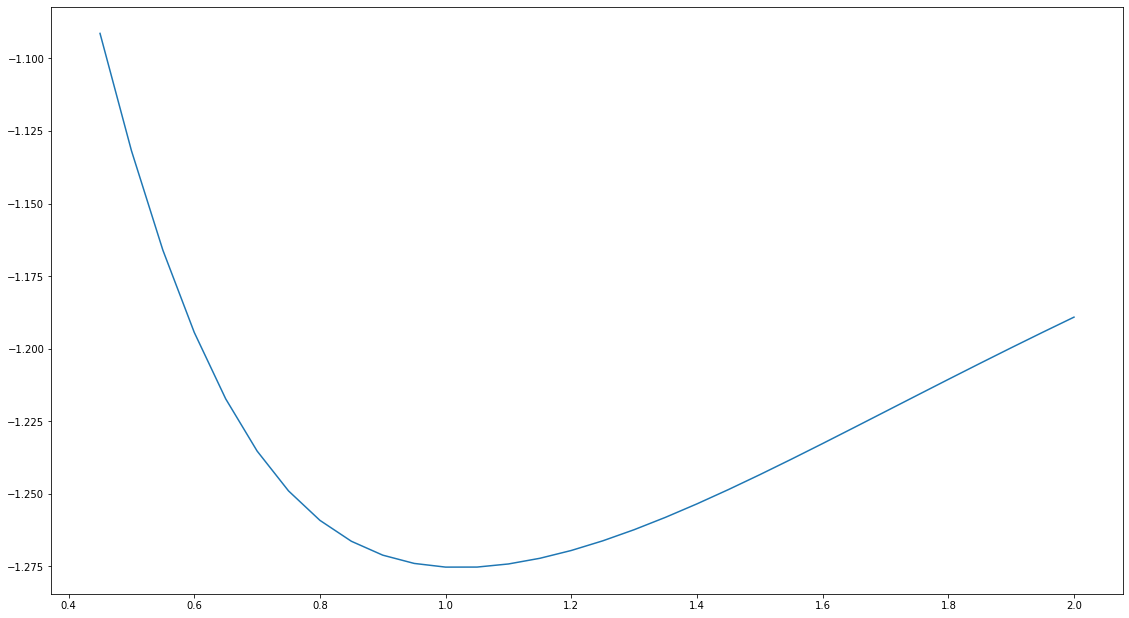

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
plt.plot(inter_atomic_dists, ryrz_total_ground_state_energies)
plt.show()

In [26]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

# if ansatz_type == "TwoLocal":
result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': qubit_converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'skip_final_rotation_layer': skip_final_rotation_layer,
    # 'energy (Ha)': energy,
    # 'error (mHa)': (energy-exact_energy)*1000,
    # 'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    # 'score': score
}

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions
0,SLSQP,TwoLocal,2,8,"[ry, rz]",cx,linear,1


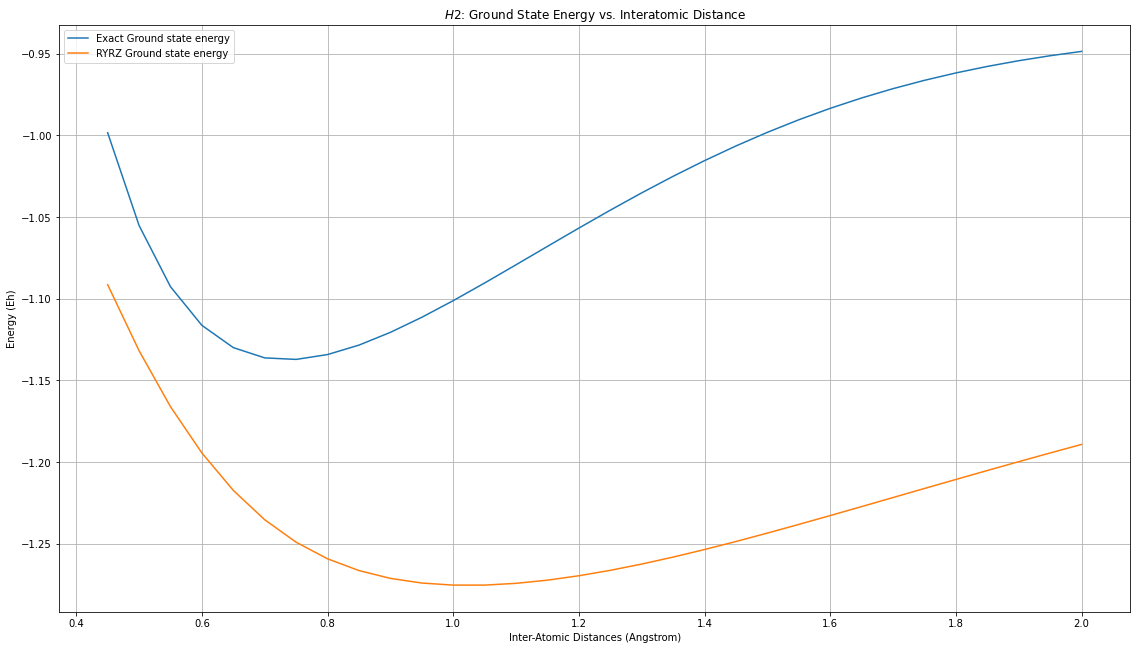

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))

plt.title(r"$H2$: Ground State Energy vs. Interatomic Distance")

ax.set_xlabel('Inter-Atomic Distances (Angstrom)')
ax.set_ylabel('Energy (Eh)')
ax.grid()

plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies, label="Exact Ground state energy")
plt.plot(inter_atomic_dists, ryrz_total_ground_state_energies, label="RYRZ Ground state energy")

plt.legend()

# fig_title = f"{result_dict['optimizer']}-{result_dict['mapping']}-{result_dict['ansatz']}.png"

fig.savefig("ryrz_vqe_h2_id_fig", dpi=300)


# Displaying and saving the data

import pandas as pd

result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks', 'entanglement', 'repetitions']]

# plt.show()

In [28]:
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation("pa")

Traceback (most recent call last):
  Input In [28] in <cell line: 1>
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation("pa")
  Input In [20] in initial_state_preparation
    qmolecule = driver.run()
  File /opt/conda/lib/python3.8/site-packages/qiskit_nature/drivers/second_quantization/pyscfd/pyscfdriver.py:410 in run
    self._build_molecule()
  File /opt/conda/lib/python3.8/site-packages/qiskit_nature/drivers/second_quantization/pyscfd/pyscfdriver.py:460 in _build_molecule
    raise QiskitNatureError("Failed to build the PySCF Molecule object.") from exc
QiskitNatureError: 'Failed to build the PySCF Molecule object.'

Use %tb to get the full traceback.


In [ ]:
init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

init_state.draw("mpl", initial_state=True)

In [ ]:
# Setting up TwoLocal for our ansatz
ansatz_type = "RYRZ"

# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ["ry", "rz"]
# Entangling gates
entanglement_blocks = "cx"
# How the qubits are entangled?
entanglement = 'linear'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1
# Skipoing the final rotation_blocks layer
skip_final_rotation_layer = False

ansatz = TwoLocal(
    qubit_op.num_qubits,
    rotation_blocks,
    entanglement_blocks,
    reps=repetitions,
    entanglement=entanglement,
    skip_final_rotation_layer=skip_final_rotation_layer,
    insert_barriers=True)

# Add the initial state
ansatz.compose(init_state, front=True, inplace=True)

In [ ]:
ansatz.draw(output="mpl", initial_state=True)

In [ ]:
ansatz.decompose().draw(output="mpl", initial_state=True)

In [ ]:
optimizer = COBYLA(maxiter=10000)

### Solver

Exact Eigensolver using NumPyMinimumEigensolver


In [ ]:
result_exact = exact_diagonalizer(es_problem, qubit_converter)
exact_energy = np.real(result_exact.eigenenergies[0])

print("Exact Electronic Energy: {:.4f} Eh\n\n".format(exact_energy))

print("Results:\n\n", result_exact)

VQE Solver

In [ ]:
from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# we choose a fixed small displacement

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    
algorithm = VQE(
    ansatz,
    optimizer=optimizer,
    quantum_instance=state_sim,
    callback=callback,
    initial_point=initial_point
)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

In [ ]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

# if ansatz_type == "TwoLocal":
result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': qubit_converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'skip_final_rotation_layer': skip_final_rotation_layer,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score}

In [ ]:
# Plotting the results

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))

# ax.set_facecolor("#293952")
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Eh)')
ax.grid()

fig.text(0.7, 0.75, f'VQE Energy: {result.optimal_value:.4f} Eh\nExact Energy: {exact_energy:.4f} Eh\nScore: {score:.0f}')

plt.title(f"Ground State Energy of H2 using RYRZ VQE Ansatz\nOptimizer: {result_dict['optimizer']} \n Mapper: {result_dict['mapping']}\nVariational Form: {result_dict['ansatz']} - RYRZ")

ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')

fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
# fig.savefig(fig_title, dpi=300)


# Displaying and saving the data

import pandas as pd

result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', 'error (mHa)', 'pass', 'score','# of parameters','rotation blocks', 'entanglement_blocks',

    'entanglement', 'repetitions']]
